# Agenda



*   Simple RNN and LSTM for forecasting (Univariate)



# Excercise: Forecasting


## 1 Step Ahead

![Forecasting Time Series](https://i.imgur.com/m88ihrK.png)

In [ ]:
from tensorflow.random import set_seed
set_seed(1612)
import numpy as np
np.random.seed(1612)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

**Functions to generate fake time series**


In [ ]:
def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0, 1, n_steps)
  # wave 1
  series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) 
  # wave 2
  series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
  # noise
  series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
  return series[..., np.newaxis].astype(np.float32)

def create_data_set(batch_size, n_steps, predict_steps, test_size): # phải hiểu 
  
  series = generate_time_series(batch_size, n_steps + predict_steps) # batch_size: số lượng tổng sample; n_steps số steps, predicts steps: dự đoán bao nhiêu ngày kế tiếp, test_size: integer để chia validation & test

  test_start = batch_size - test_size # lấy index ban đầu 
  X_test = series[test_start:, :n_steps]
  y_test = series[test_start:, n_steps:]

  val_start = test_start - test_size
  X_val = series[val_start:test_start, :n_steps]
  y_val = series[val_start:test_start, n_steps:]

  X_train = series[:val_start, :n_steps]
  y_train = series[:val_start, n_steps:]
  
  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# TODO
# 1. Use create_data_set_function() to create data with 
#### 10000 samples
#### 50 time_steps
#### 1 predict_steps
#### test_size (& validation size should be the same) = 1000
# 2. print out the shape
X_train, y_train, X_val, y_val, X_test, y_test = create_data_set(10000, 50, 1, 1000) # 1 cuối là số features
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (8000, 50, 1)
y_train:  (8000, 1, 1)
X_val:  (1000, 50, 1)
y_val:  (1000, 1, 1)
X_test:  (1000, 50, 1)
y_test:  (1000, 1, 1)


### Visualize Series

In [ ]:
def plot_series(series, n_steps, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "gx", markersize=10) #'gx' chấm chữ x và green
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro") #'ro' chấm o màu red
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

def plot_all_series(rows, cols, X, y_true, y_pred=None):
  fig, axes = plt.subplots(nrows=rows, ncols=cols, sharey=True, figsize=(20, 20))
  for row in range(rows): # rows = 10
    for col in range(cols): # cols = 5
        plt.sca(axes[row][col])
        if y_pred is not None:
          plot_series(X_test[row * 10 + col, :, 0], 50, y_test[row * 10 + col, 0],
                y_pred[row * 10 + col, 0], y_label=("$x(t)$" if col==0 else None))
        else:
          plot_series(X_test[row * 10 + col, :, 0], 50, y_test[row * 10 + col, 0],
                  y_label=("$x(t)$" if col==0 else None))
  plt.show()



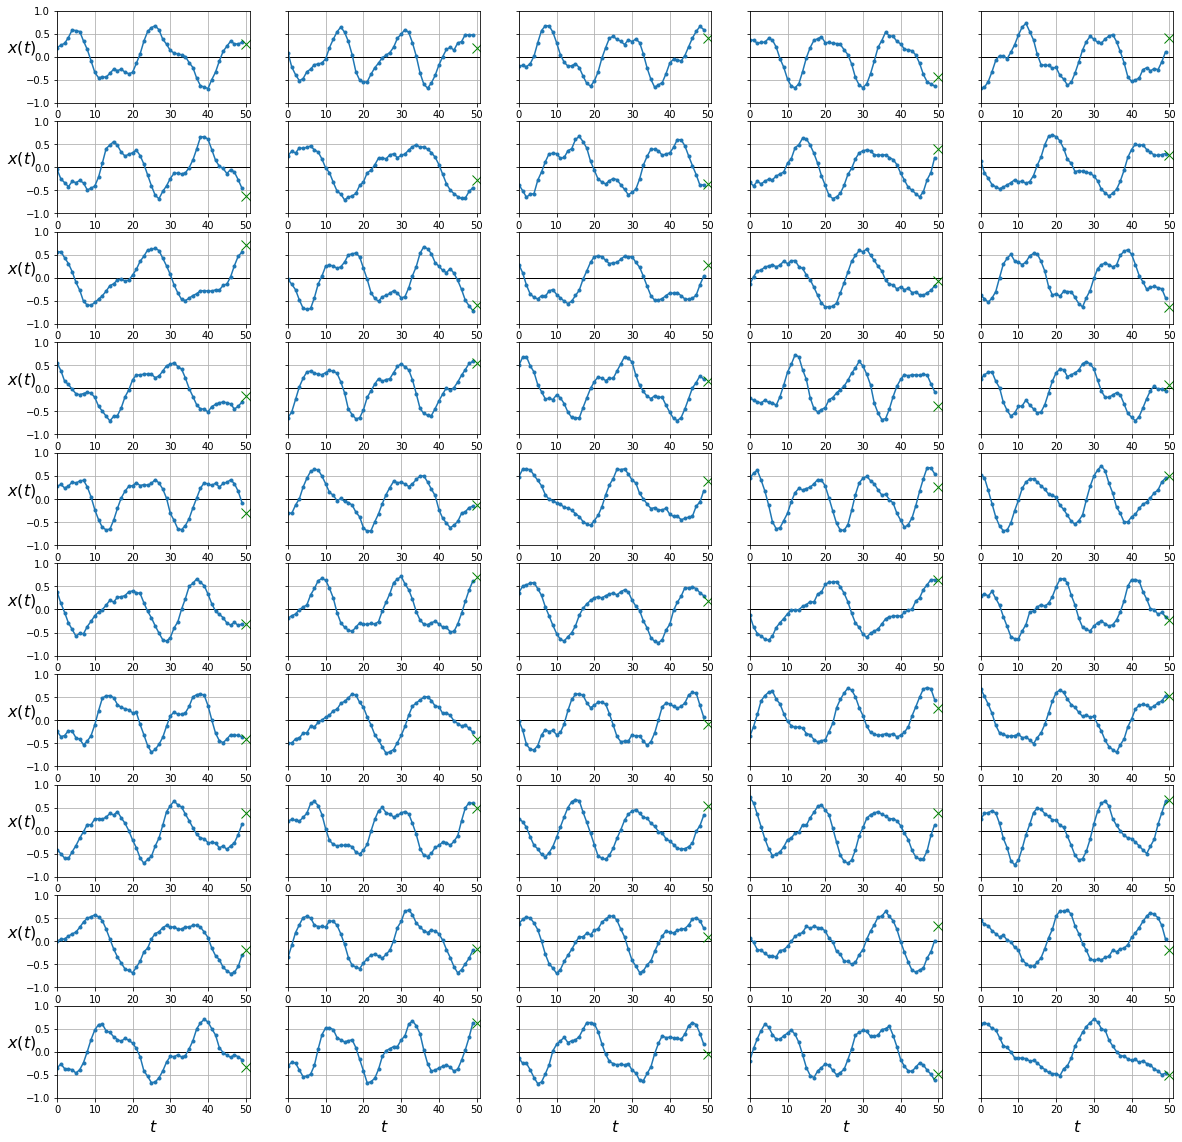

In [ ]:
# TODO
# 1. call plot_all_series() to visualize all data in Test Set
plot_all_series(10, 5, X_test, y_test) 

### Baseline Model

In [ ]:
# TODO
# 1. complete plot_learning_curves() function to DRAW LOSS VS EPOCHS

def plot_learning_curves(history):
  plt.figure(figsize=(10,5))
  plt.plot(history.history['loss'], 'b.-', label='Training Loss')
  plt.plot(history.history['val_loss'], 'r.-', label='Validation Loss')
  plt.legend(fontsize=14)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.show()

#### Naive Approach

Assumse that value at time step 50 is close to value at time step 49

**Noted**

Use np.squeeze before apply MSE

In [ ]:
print(y_pred.shape)

(1000, 1)


In [ ]:
# TODO
# Implement naive approach
from tensorflow.keras.losses import MSE
y_pred = X_test[:,-1,:] # giá trị ngày 50 gán thành y_pred # 1st: số sample, 2nd Time step lấy số ngày lớn nhất, Chiều thứ 3: vector nhúng sao cho tính norm 2 vectors gần nhau
print(MSE(np.squeeze(y_test), np.squeeze(y_pred))) #y_test giá trị ngày 51 
# 2 giá trị gần gần nhau tính ra MSE để ko bị âm 

tf.Tensor(0.020530049, shape=(), dtype=float32)


#### Linear Regression

In [ ]:
# TODO
# 1. Implement a Linear Regression Model using Keras
# 2. Evaluate on Test Set
# 3. Plot Learning Curve
lin_model = Sequential()
lin_model.add(Flatten(input_shape=X_train.shape[1:]))
lin_model.add(Dense(1)) # 1 output là 1 con số # đây cũng là output luôn
lin_model.compile(loss='mse', optimizer='adam') # ko cần metrics do loss là metrics rồi
history = lin_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val)) # bỏ luôn shuffle, batch size

Epoch 1/20
250/250 [==============================] - 0s 1ms/step - loss: 0.1654 - val_loss: 0.0596
Epoch 2/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0353 - val_loss: 0.0233
Epoch 3/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0161 - val_loss: 0.0126
Epoch 4/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 5/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0069
Epoch 6/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 7/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 8/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 9/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 10/20
250/250 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0046

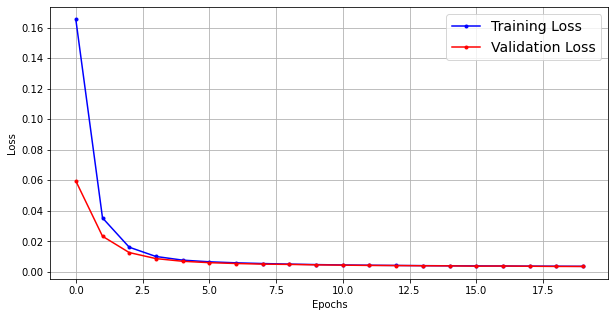

In [ ]:
plot_learning_curves(history)

32/32 [==============================] - 0s 987us/step - loss: 0.0034


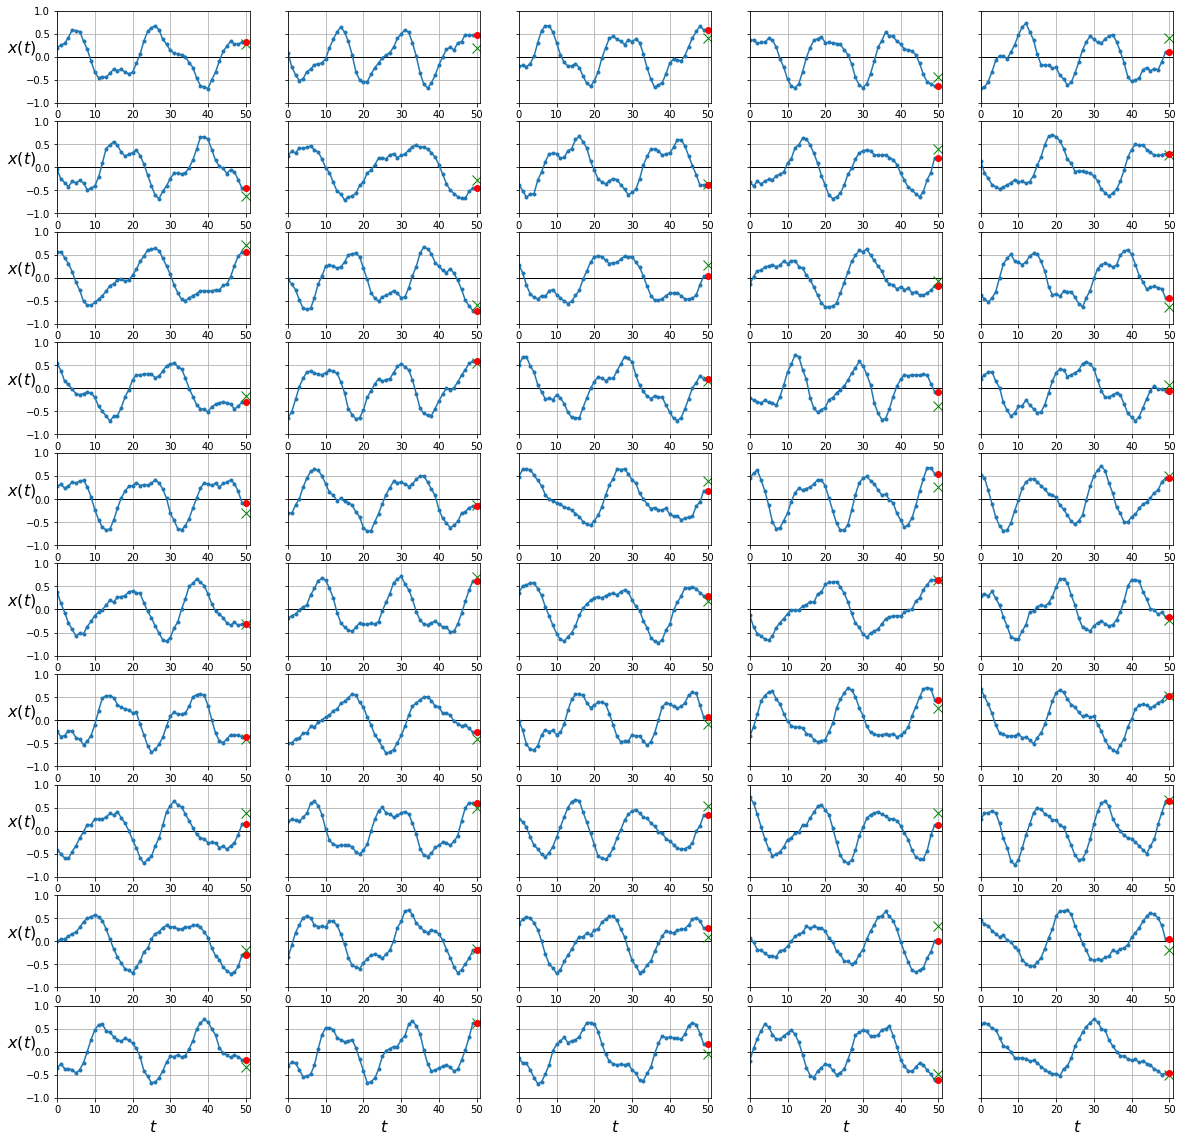

In [ ]:
# TODO
# 1. Predict on Test Set
# 2. Call plot_all_series() to draw 
lin_model.evaluate(X_test, y_test)
plot_all_series(10, 5, X_test, y_test, y_pred) # do đã tính đc y_pred rồi

### A Simple RNN

In [ ]:
# TODO
# 1.Implement a Simple RNN model
#### Using SimpleRNN layer with units = 1
# 2. Evaluate on Test Set
# 3. Plot Learning Curve
model = Sequential()
model.add(SimpleRNN(1,input_shape=X_train.shape[1:]))
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
250/250 [==============================] - 2s 7ms/step - loss: 0.1444 - val_loss: 0.1451
Epoch 2/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1414 - val_loss: 0.1446
Epoch 3/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1420 - val_loss: 0.1452
Epoch 4/20
250/250 [==============================] - 2s 7ms/step - loss: 0.1427 - val_loss: 0.1469
Epoch 5/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1412 - val_loss: 0.1457
Epoch 6/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1413 - val_loss: 0.1450
Epoch 7/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1415 - val_loss: 0.1444
Epoch 8/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1416 - val_loss: 0.1455
Epoch 9/20
250/250 [==============================] - 2s 7ms/step - loss: 0.1420 - val_loss: 0.1444
Epoch 10/20
250/250 [==============================] - 2s 6ms/step - loss: 0.1414 - val_loss: 0.1448

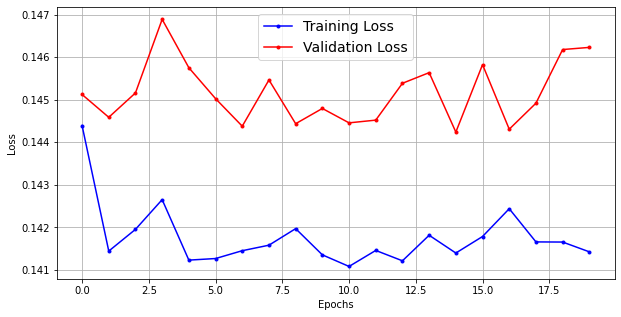

In [ ]:
plot_learning_curves(history)

Since this model is too simple, it can not generalize well

In [ ]:
model.summary()
# chỉ có 3 weights

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


32/32 [==============================] - 0s 3ms/step - loss: 0.1530


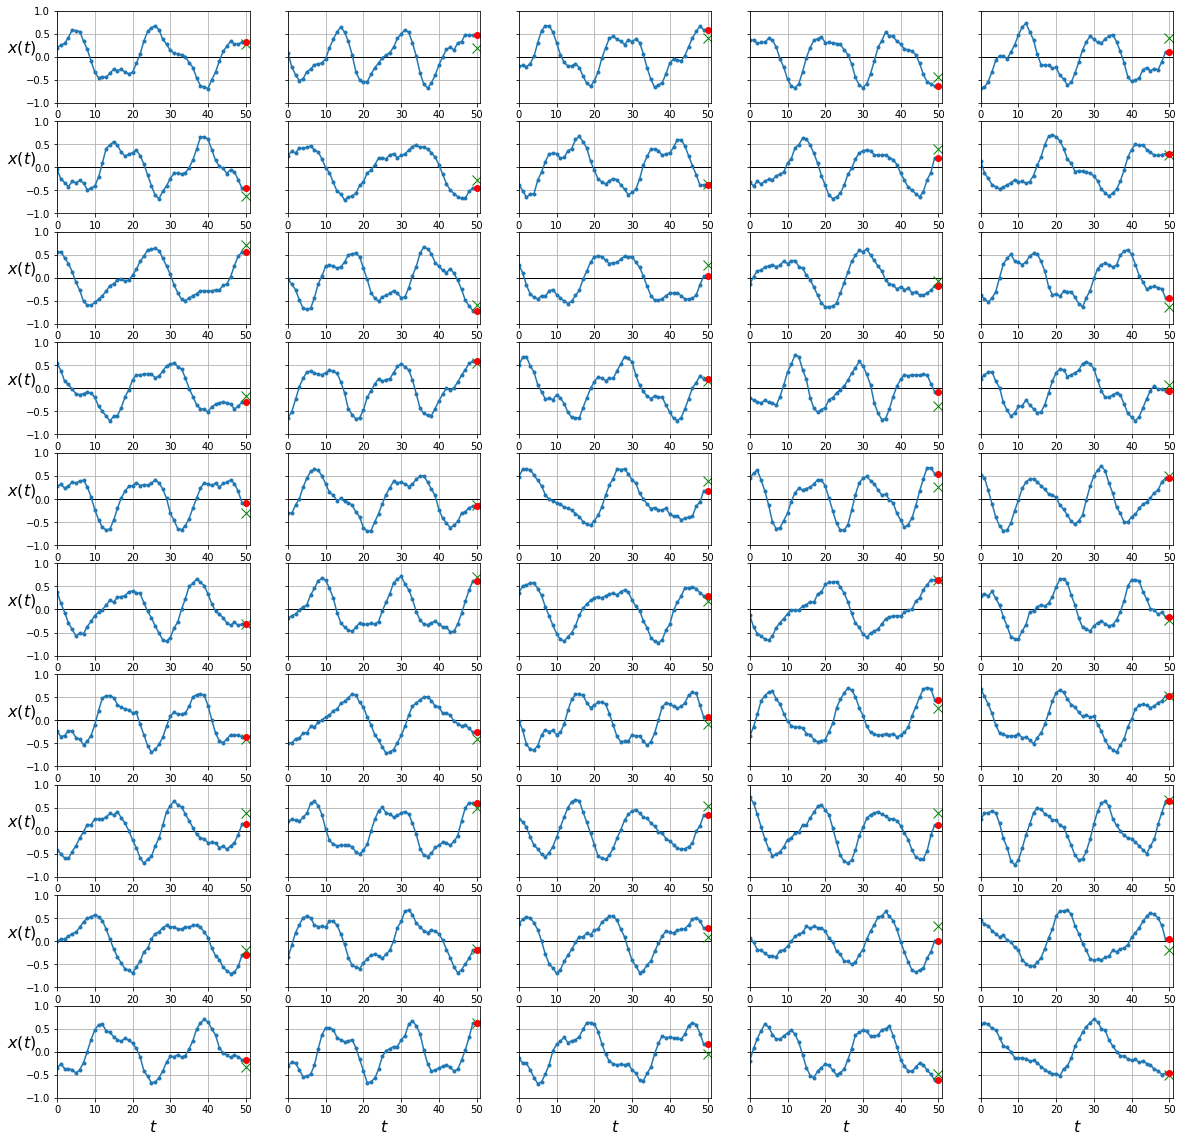

In [ ]:
# TODO
# 1. Predict on Test Set
# 2. Call plot_all_series() to draw 
model.evaluate(X_test, y_test)
plot_all_series(10,5, X_test, y_test, y_pred)

### Deep RNN

In [ ]:
# TODO
# 1. Implement a Deep RNN with 2 SimpleRNN layers with 20 units each
# 2. Evaluate on Test Set
# 3. Plot Learning Curve
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True ,input_shape=X_train.shape[1:])) # (8000,50,1)
model.add(SimpleRNN(20)) # (8000,50,20) # stack 2 RNN lại thì phải có return_sequences
model.add(Dense(1)) # 1
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))
#model.summary()

Epoch 1/20
250/250 [==============================] - 4s 18ms/step - loss: 0.0206 - val_loss: 0.0063
Epoch 2/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 3/20
250/250 [==============================] - 4s 18ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 6/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 7/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/20
250/250 [==============================] - 4s 18ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/20
250/250 [==============================] - 4s 18ms/step - loss: 0.0028 - val_lo

32/32 [==============================] - 0s 5ms/step - loss: 0.0026


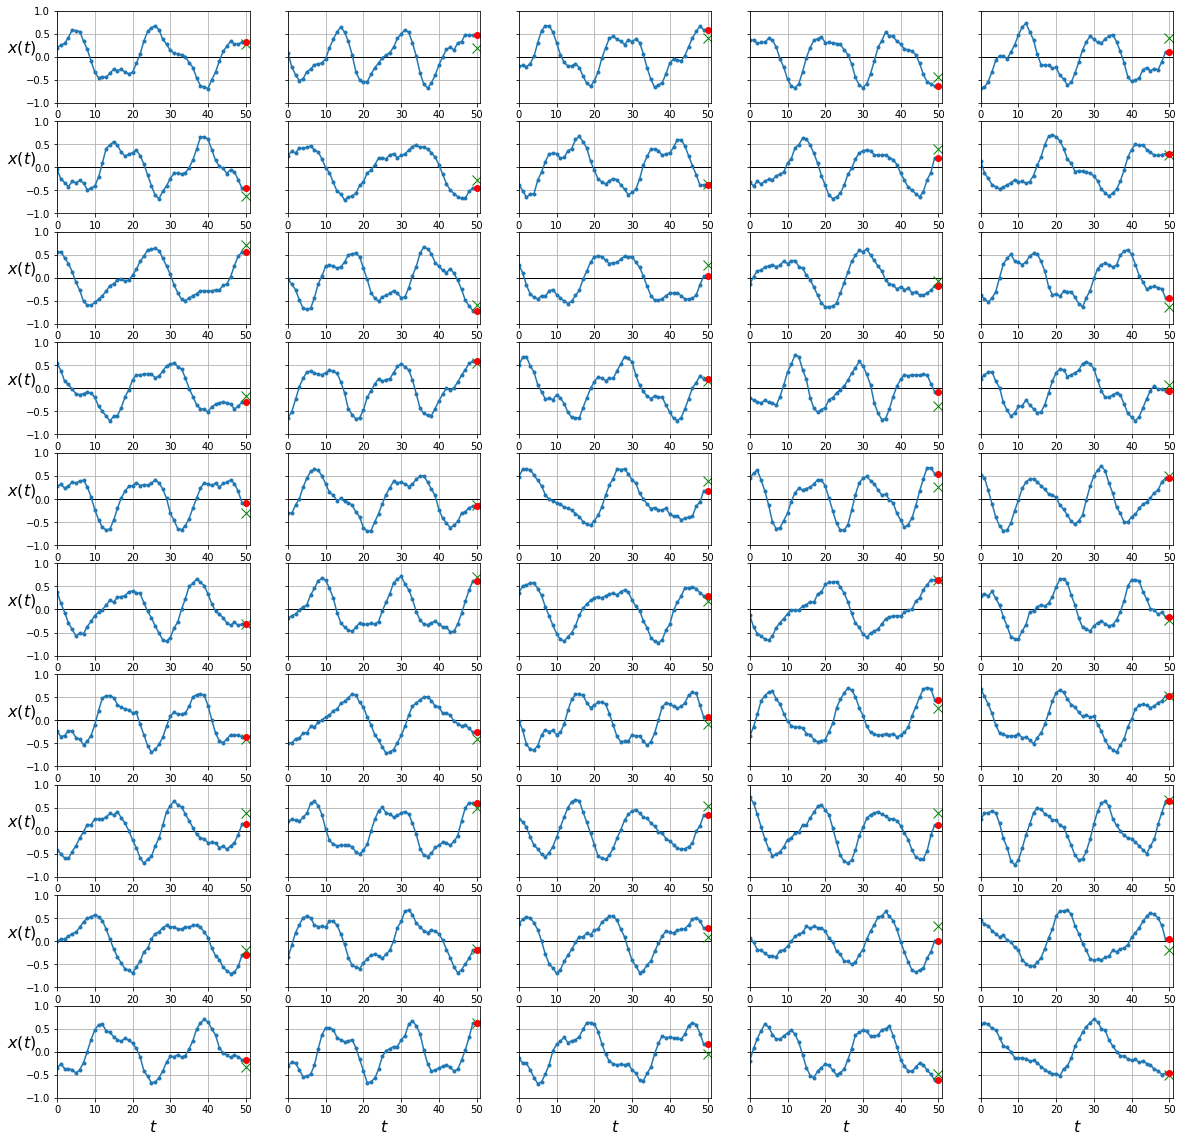

In [ ]:
# TODO
# 1. Predict on Test Set
# 2. Call plot_all_series() to draw 
model.evaluate(X_test, y_test)
plot_all_series(10,5, X_test, y_test, y_pred)
# Giảm đc Loss từ 0.0036 còn 0.0026 

## Several Steps Ahead

In [ ]:
# TODO
# 1. Use create_data_set_function() to create data with 
#### 10000 samples
#### 50 time_steps
#### 10 predict_steps --> dự đoán 10 ngày kế tiếp
#### test_size (validation size should be the same) = 1000
# 2. print out the shape
X_train, Y_train, X_val, Y_val, X_test, Y_test = create_data_set(10000, 50, 10, 1000) # 1 cuối là số features
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)
print('X_val: ', X_val.shape)
print('Y_val: ', Y_val.shape)
print('X_test: ', X_test.shape)
print('Y_test: ', Y_test.shape)
# Nãy là vector, giờ là matrix

X_train:  (8000, 50, 1)
Y_train:  (8000, 10, 1)
X_val:  (1000, 50, 1)
Y_val:  (1000, 10, 1)
X_test:  (1000, 50, 1)
Y_test:  (1000, 10, 1)


### Visualize Series

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred=None):
  plt.figure(figsize=(10,5))
  n_steps = X.shape[1]
  ahead = Y.shape[1]
  plot_series(X[0, :, 0], 50) # Số 0 đầu đang là mẫu đầu. Thay sang các mẫu khác bằng thay số 1, 2
  plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
  if Y_pred is not None:
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :], "bx-", label="Forecast", markersize=10)
  plt.axis([0, n_steps + ahead, -1, 1])
  plt.legend(fontsize=14)
  plt.show()

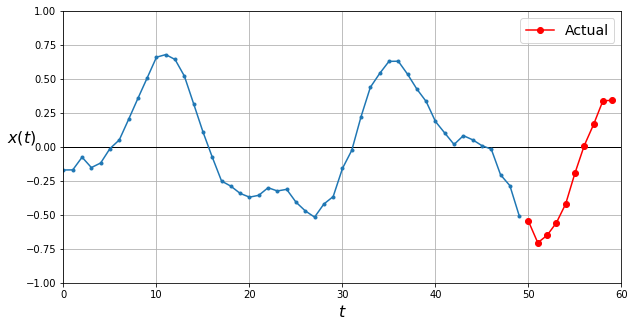

In [ ]:
# TODO
# 1. call plot_multiple_forecast() on Test Set
plot_multiple_forecasts(X_test, Y_test)

### Deep RNN

In [ ]:
# TODO
# 1. implement a DeepRNN again but this time has 10 outputs
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True ,input_shape=X_train.shape[1:])) # (8000,50,1)
model.add(SimpleRNN(20)) # (8000,50,20) # stack 2 RNN lại thì phải có return_sequences
model.add(Dense(10)) # 10
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val))

Epoch 1/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0432 - val_loss: 0.0213
Epoch 2/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0190 - val_loss: 0.0190
Epoch 3/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0153 - val_loss: 0.0136
Epoch 4/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 5/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0124 - val_loss: 0.0132
Epoch 6/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0115 - val_loss: 0.0139
Epoch 7/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 8/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 9/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0101 - val_loss: 0.0102
Epoch 10/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0098 - val_lo

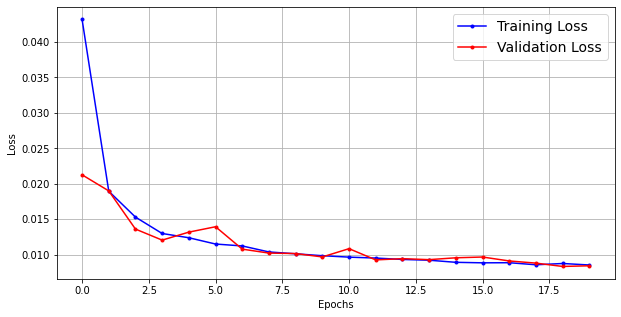

In [ ]:
plot_learning_curves(history)

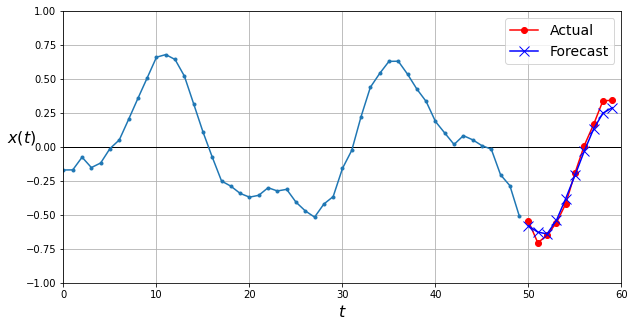

In [ ]:
Y_pred = model.predict(X_test)
plot_multiple_forecasts(X_test, Y_test, Y_pred)

## Predict 10 values at each time step

In [ ]:
# 1-> 10, 2-> 11
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:8000, :n_steps]
X_val = series[8000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:8000]
Y_val = Y[8000:9000]
Y_test = Y[9000:]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)
# 50 time steps, mỗi step có 10 giá trị

(8000, 50, 1) (8000, 50, 10)
(1000, 50, 1) (1000, 50, 10)
(1000, 50, 1) (1000, 50, 10)


### Deep RNN

In [ ]:
# TODO 
# implement DeepRNN ... again
model = Sequential()
model.add(SimpleRNN(20, return_sequences=True ,input_shape=X_train.shape[1:])) 
model.add(SimpleRNN(20, return_sequences=True)) 
model.add(Dense(10)) # 10
def mse_at_last_step(Y_true, Y_pred):
    return MSE(Y_true[:,-1], Y_pred[:,-1]) # chỉ tính cái cuối 3 in ra matrix cuối cùng từ 51 tới 60
model.compile(loss='mse', optimizer='adam', metrics=mse_at_last_step)
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val))
model.evaluate(X_test, Y_test)

Epoch 1/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0618 - mse_at_last_step: 0.0501 - val_loss: 0.0426 - val_mse_at_last_step: 0.0277
Epoch 2/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0396 - mse_at_last_step: 0.0252 - val_loss: 0.0392 - val_mse_at_last_step: 0.0242
Epoch 3/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0362 - mse_at_last_step: 0.0213 - val_loss: 0.0354 - val_mse_at_last_step: 0.0198
Epoch 4/20
250/250 [==============================] - 4s 17ms/step - loss: 0.0336 - mse_at_last_step: 0.0183 - val_loss: 0.0327 - val_mse_at_last_step: 0.0167
Epoch 5/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0323 - mse_at_last_step: 0.0171 - val_loss: 0.0320 - val_mse_at_last_step: 0.0153
Epoch 6/20
250/250 [==============================] - 4s 16ms/step - loss: 0.0310 - mse_at_last_step: 0.0158 - val_loss: 0.0305 - val_mse_at_last_step: 0.0144
Epoch 7/20
250/250 [==========================

[0.02461121790111065, 0.01108705997467041]

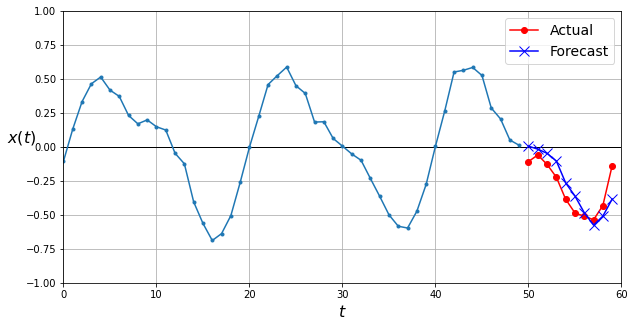

In [ ]:
Y_pred = model.predict(X_test)[:, -1][...,None]
Y_true = Y_test[:,-1][...,None]

plot_multiple_forecasts(X_test, Y_true, Y_pred)
# Đầu: tới cuối mới return 10 cái
# Này: return 10 cái mỗi step

### LSTM

In [ ]:
# TODO
# 1. Implement LSTM model
# 2. call plot multiple_forecast